# **Routing Pattern**

The **Routing Pattern** enables **adaptive decision-making** in agentic systems, allowing dynamic control flow instead of fixed, linear prompt chains. It lets agents **evaluate input context or system state** to determine which specialized function, tool, or sub-agent to invoke next.

---

### **Key Aspects**

- **Purpose:** Moves beyond deterministic workflows by introducing **conditional logic** that allows context-aware branching.  
- **Mechanism:** The agent analyzes input (e.g., user intent, task type) and routes execution accordingly — e.g., to order lookup, product info retrieval, or human escalation.  

---

### **Core Implementations**

1. **LLM-based Routing** – The model outputs a route/category based on prompt analysis.  
2. **Embedding-based Routing** – Uses semantic similarity between input and route embeddings.  
3. **Rule-based Routing** – Relies on deterministic if-else or pattern-based logic.  
4. **ML Model-based Routing** – Uses a fine-tuned classifier for routing decisions.  

---

### **Integration Points**

Routing can occur at:
- **Start:** For primary task classification  
- **Mid-process:** For conditional branching  
- **Subroutines:** For dynamic tool selection  

---

### **Framework Support**

Platforms like **LangChain**, **LangGraph**, and **Google’s ADK** provide constructs for defining and managing routing logic:
- **LangGraph** excels in **state-based, multi-branch flows**
- **ADK** supports modular agent capability structuring  

---

### **Applications**

- **Conversational Agents:** Intent-based query handling  
- **Data/Document Pipelines:** Automated classification and workflow dispatching  
- **Multi-Agent Systems:** Task delegation among specialized agents  

---

### **Essence**

Routing transforms an agent from a **static executor** into a **context-aware, intelligent orchestrator** capable of **dynamic, goal-directed action selection**.


In [1]:
from IPython.display import display, Image
from dotenv import load_dotenv
from typing import TypedDict

from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, AnyMessage, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate

In [2]:
class GraphState(TypedDict):
    query: str
    response: str

In [3]:
# Step 1: Define the agent function that determines routing
def classify_intent(state: GraphState) -> GraphState:
    query = state["query"].lower()
    if "order" in query:
        return "order_status"
    elif "product" in query:
        return "product_info"
    elif "support" in query:
        return "technical_support"
    else:
        return "clarification"

In [4]:
# Step 2: Define functions for each route
def handle_order(state:GraphState) -> GraphState:
    print("→ Fetching order details...")
    return {"response": "Your order is being processed."}

def handle_product(state:GraphState) -> GraphState:
    print("→ Searching product information...")
    return {"response": "Here’s the product info you requested."}

def handle_support(state:GraphState) -> GraphState:
    print("→ Initiating technical support...")
    return {"response": "Let’s troubleshoot your issue."}

def handle_clarification(state: GraphState) -> GraphState:
    print("→ Asking for clarification...")
    return {"response": "Can you please clarify your request?"}

### Building Graph
- `with no-op passthough`

In [8]:
# Step 3: Build the LangGraph routing flow
# This is another way of defining graph schema rather than a custom class
graph = StateGraph(GraphState)

# ✅ Router node should return a dict, not a string
#    So we make it a no-op (pass-through)
graph.add_node("router", lambda state: state)

# Define route nodes
graph.add_node("order_status", handle_order)
graph.add_node("product_info", handle_product)
graph.add_node("technical_support", handle_support)
graph.add_node("clarification", handle_clarification)

# Step 4: Add edges (conditional routing)
graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    classify_intent,  # routing function
    {
        "order_status": "order_status",
        "product_info": "product_info",
        "technical_support": "technical_support",
        "clarification": "clarification"
    }
)

# End each route
graph.add_edge("order_status", END)
graph.add_edge("product_info", END)
graph.add_edge("technical_support", END)
graph.add_edge("clarification", END)

app = graph.compile()

### Building Graph
- `without no-op workthrough`

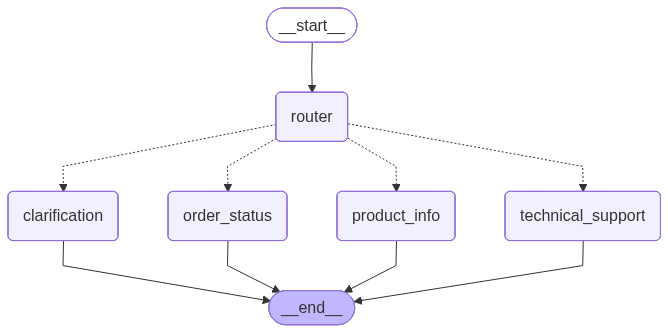

In [10]:
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
# Step 3: Build the LangGraph routing flow
# This is another way of defining graph schema rather than a custom class
graph = StateGraph(GraphState)

# Define route nodes
graph.add_node("order_status", handle_order)
graph.add_node("product_info", handle_product)
graph.add_node("technical_support", handle_support)
graph.add_node("clarification", handle_clarification)

# Step 4: Add edges (conditional routing)
graph.add_conditional_edges(
    START,
    classify_intent,  # routing function
    {
        "order_status": "order_status",
        "product_info": "product_info",
        "technical_support": "technical_support",
        "clarification": "clarification"
    }
)

# End each route
graph.add_edge("order_status", END)
graph.add_edge("product_info", END)
graph.add_edge("technical_support", END)
graph.add_edge("clarification", END)

app2 = graph.compile()

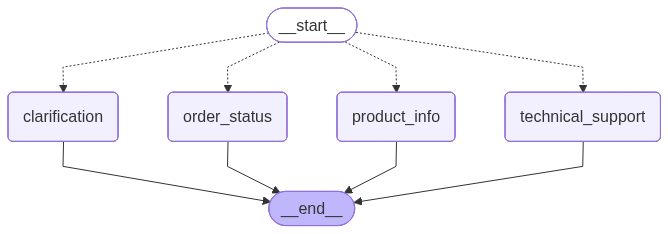

In [13]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [14]:
result = app.invoke({"query": "I need help with my order"})

→ Fetching order details...


In [15]:
print("Final Output:", result["response"])

Final Output: Your order is being processed.


### Troubleshooting

In [16]:
app.nodes

{'__start__': <langgraph.pregel._read.PregelNode at 0x1f8df0c4d90>,
 'router': <langgraph.pregel._read.PregelNode at 0x1f8df0c4190>,
 'order_status': <langgraph.pregel._read.PregelNode at 0x1f8df0c6e10>,
 'product_info': <langgraph.pregel._read.PregelNode at 0x1f8df0c64d0>,
 'technical_support': <langgraph.pregel._read.PregelNode at 0x1f8df0c4c50>,
 'clarification': <langgraph.pregel._read.PregelNode at 0x1f8df0c6890>}

In [18]:
for step in app.stream({"query": "need tech support"}):
    print("🧩 Step:", step)

🧩 Step: {'router': {'query': 'need tech support'}}
→ Initiating technical support...
🧩 Step: {'technical_support': {'response': 'Let’s troubleshoot your issue.'}}
